## Problem Formulation


## What is the input ? 
* the input data is a graphs that represent chemical compounds 
* The atoms of the chemical compound representing nodes and bonds as edges



## What is the output?
* to determine whether the compound is either poistive or negative against non-small cell lung cancer 
* we have two classification class 
* 1 for positive class 
* 0 for negative class

## What data mining function is required?
* The data mining in this problem is Classification & Prediction

## What could be the challenges?
* reading SDF format
* soliving the unbalance across the data 
* extracting important features from data file 
* using some layers to prevent overfitting.

## What is the impact?
* to know whether the Drug will affect the cancer or not 

## What is an ideal solution?
the ideal solution is to clean and preprocess the data before working with it

Some of the possible solutions are:

* Up-sampling imbalanced data to deal with it
*  Before dealing with the text data (that represent the atom name in the chemical compound), preprocess it.

## What is the experimental protocol used and how was it carried out?
The experimental protocol involves loading the data, cleaning and preprocessing it, and then dividing the training dataset into a training_set and a validation_set. The new training_set is used to fit the model, the validation_set is used to measure the model's performance (AUROC), and the original test dataset is used to make the prediction.

## What preprocessing steps are used?
* investigate the data and fully understand it
* The training data should be adjusted to "up-sample" the positive class samples.
* processing text data by  :
    *    a tokenizer, build a vocabulary from the Training set.
    *    the method pad_sequences()
*    For each sample in gen_batch, execute prepare_single_batch.





In [1]:
## imports
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve
from tqdm.notebook import tqdm
import os
import math
sns.set()

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from time import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:

from sklearn.utils import resample 
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

In [3]:

from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import GRU, LSTM, Bidirectional

In [4]:

!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput
from tf2_gnn.layers.message_passing import GNN_Edge_MLP, GNN_FiLM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.0/388.0 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.9/173.9 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.6 MB/s eta 0:00:00


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
## adjusting print settings for pandas 
pd.options.display.max_columns = 100
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

## Loading The Data 

In [7]:
from google.colab import drive

In [8]:
#connect to drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
        #split each sample alone by ($$$$)
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        #if the label : ==1 leave it as it is, if ==-1 make it 0.
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                #edge represent link between each two nodes
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]

In [10]:
## loading the data
train_data = read_sdf("/content/drive/MyDrive/Anti-cancer/train.sdf")
test_data = read_sdf("/content/drive/MyDrive/Anti-cancer/test_x.sdf")

  0%|          | 0/25024 [00:00<?, ?it/s]

  0%|          | 0/12326 [00:00<?, ?it/s]

In [12]:
# invistigating the data 
print(train_data[0])

(['S', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  8],
       [ 0, 14],
       [ 1, 10],
       [ 2, 11],
       [ 3,  7],
       [ 4,  7],
       [ 5,  9],
       [ 5, 14],
       [ 6, 14],
       [ 6, 17],
       [ 7, 22],
       [ 8,  9],
       [ 8, 10],
       [ 9, 11],
       [10, 12],
       [11, 13],
       [12, 13],
       [12, 15],
       [13, 16],
       [15, 18],
       [16, 19],
       [17, 20],
       [17, 21],
       [18, 19],
       [20, 23],
       [21, 24],
       [22, 23],
       [22, 24]]), 0)


# Data Up-Sampling


In [13]:
np.unique(np.array(train_data)[:,2],return_counts=True)


(array([0, 1], dtype=object), array([23806,  1218]))

In [14]:
# converting train into DataFrame
train_df = pd.DataFrame(train_data, columns=['node','edge','label']) 

In [15]:
# print the count of 0,1 in the label column
print(train_df['label'].value_counts())

0    23806
1     1218
Name: label, dtype: int64


In [16]:
# gettig negative class (label = 0)
class_0 = train_df[train_df['label'] == 0]
# getting possitive class (label = 1)   
class_1 = train_df[train_df['label'] == 1] 
 # resample class_1
class_1 = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
# get upsampled data 
upsampled_data = pd.concat([class_1, class_0])  

In [17]:

# print the count of 0,1 in the label column after data up-sampling
print(upsampled_data["label"].value_counts())

1    23806
0    23806
Name: label, dtype: int64


In [18]:
# convert upsampled_data from DataFrame to an array 
data_upsampled = upsampled_data.to_numpy()

## splitting the Data

In [19]:
# splitting the upsampled data
training_set, validation_set = train_test_split(data_upsampled, test_size=0.2)

## Visualizing the data 

In [20]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm
colors = cm.rainbow(np.linspace(0, 1, 50))

In [21]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

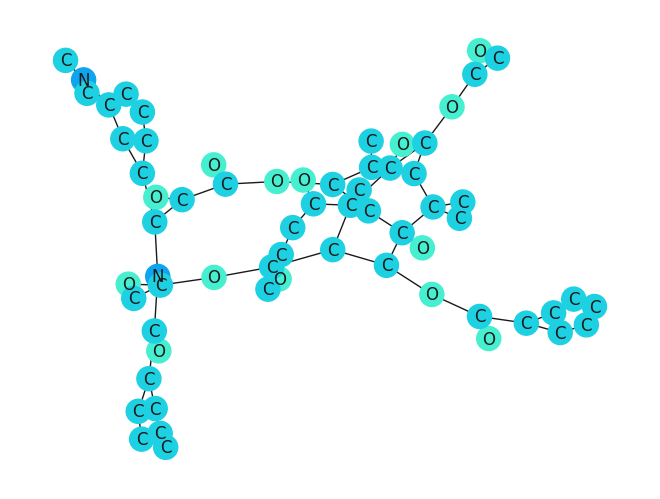

In [22]:
plt.clf()
visualize(training_set[0])

## Data Preprocessing

In [23]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    sample_nodes = [s[0] for s in samples]
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])

In [25]:
def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break

In [26]:
# showing one batch:
for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break
     

data
[5 2 2 2 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 5 2 2 2 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
edges
[[  0  22]
 [  1  13]
 [  2  15]
 [  3  38]
 [  3  45]
 [  4   5]
 [  4  15]
 [  5  16]
 [  6  21]
 [  6  31]
 [  6  32]
 [  7   8]
 [  7  16]
 [  8  30]
 [  9  43]
 [ 10  44]
 [ 11  12]
 [ 11  13]
 [ 11  20]
 [ 12  15]
 [ 12  18]
 [ 13  19]
 [ 14  16]
 [ 14  17]
 [ 14  24]
 [ 17  23]
 [ 17  29]
 [ 18  22]
 [ 19  27]
 [ 19  28]
 [ 20  25]
 [ 21  23]
 [ 21  26]
 [ 22  25]
 [ 24  26]
 [ 27  33]
 [ 28  34]
 [ 30  36]
 [ 30  37]
 [ 31  39]
 [ 32  40]
 [ 33  35]
 [ 34  35]
 [ 36  41]
 [ 37  42]
 [ 38  41]
 [ 38  42]
 [ 39  43]
 [ 40

## Function to save the Predictions

In [27]:
#  function to save the csv results
def saveResult(y_pred, fileName):
  submission = pd.DataFrame({'label': y_pred})
  submission.index.name = 'id'
  
  submission.to_csv(fileName)

# The Trails

## Trial_1
* Model : GNN 
* data : Not upsampled
* Hidden_dim : 32
* Batch_size : 16
* epochs : 10

# Model

In [ ]:

data = keras.Input(batch_shape=(None,)) #Input layer for nodes (tokenized text data) 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32

# Graph Neural Network layer with defined hyperparameters
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)


# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn/StatefulPartitionedCall:0', description="created by layer 'gnn'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean/SegmentMean:0', description="created by layer 'tf.math.segment_mean'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense/Sigmoid:0', description="created by layer 'dense'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                      

In [ ]:
## compiling the model
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

# Model Fitting

In [ ]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)


Epoch 1/10
2381/2381 [==============================] - 60s 24ms/step - loss: 0.6414 - auc: 0.6792 - val_loss: 0.6139 - val_auc: 0.7264
Epoch 2/10
2381/2381 [==============================] - 82s 34ms/step - loss: 0.5959 - auc: 0.7443 - val_loss: 0.5841 - val_auc: 0.7625
Epoch 3/10
2381/2381 [==============================] - 56s 23ms/step - loss: 0.5778 - auc: 0.7651 - val_loss: 0.5701 - val_auc: 0.7789
Epoch 4/10
2381/2381 [==============================] - 56s 24ms/step - loss: 0.5633 - auc: 0.7822 - val_loss: 0.5614 - val_auc: 0.7952
Epoch 5/10
2381/2381 [==============================] - 56s 23ms/step - loss: 0.5435 - auc: 0.8014 - val_loss: 0.5351 - val_auc: 0.8127
Epoch 6/10
2381/2381 [==============================] - 53s 22ms/step - loss: 0.5325 - auc: 0.8122 - val_loss: 0.5364 - val_auc: 0.8178
Epoch 7/10
2381/2381 [==============================] - 56s 24ms/step - loss: 0.5184 - auc: 0.8236 - val_loss: 0.5201 - val_auc: 0.8291
Epoch 8/10
2381/2381 [==========================

## saving predictions results

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 5s 6ms/step


In [ ]:
saveResult(y_pred, 'trial_1.csv')

## Thoughts and observations for trial 1, plan for trial 2:

since our task is bioassay for anti cancer prediction , where each chemical compound is  represented as a graph i used `GNN` 

i used the default hyperparameters except for the hidden_dim which i set it to be 32  

**The results**
* Traing : around 84 % 
* kaggle public score : 82% 

oberservations : since the data where not upsaplmed the accuracy is not considered to be good enough 

Plans :  try using the same model but this time with upsamled data 


## Trial_2
* Model : GNN 
* data : upsampled
* Hidden_dim : 32
* Batch_size : 16
* epochs : 10

# Model

In [ ]:

data = keras.Input(batch_shape=(None,)) #Input layer for nodes (tokenized text data) 

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32

# Graph Neural Network layer with defined hyperparameters
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)



avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)
print('mean:', avg)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
# printing summary of the model
model.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_1/StatefulPartitionedCall:0', description="created by layer 'gnn_1'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_1/SegmentMean:0', description="created by layer 'tf.math.segment_mean_1'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_1/Sigmoid:0', description="created by layer 'dense_1'")
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []        

In [ ]:
## Model compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

# Fitting the model

In [ ]:

batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2381/2381 [==============================] - 73s 29ms/step - loss: 0.6372 - auc: 0.6857 - val_loss: 0.6050 - val_auc: 0.7338
Epoch 2/10
2381/2381 [==============================] - 64s 27ms/step - loss: 0.5942 - auc: 0.7474 - val_loss: 0.5769 - val_auc: 0.7640
Epoch 3/10
2381/2381 [==============================] - 53s 22ms/step - loss: 0.5740 - auc: 0.7715 - val_loss: 0.5649 - val_auc: 0.7867
Epoch 4/10
2381/2381 [==============================] - 54s 23ms/step - loss: 0.5555 - auc: 0.7893 - val_loss: 0.5378 - val_auc: 0.8031
Epoch 5/10
2381/2381 [==============================] - 61s 26ms/step - loss: 0.5379 - auc: 0.8059 - val_loss: 0.5194 - val_auc: 0.8217
Epoch 6/10
2381/2381 [==============================] - 53s 22ms/step - loss: 0.5246 - auc: 0.8172 - val_loss: 0.5210 - val_auc: 0.8249
Epoch 7/10
2381/2381 [==============================] - 55s 23ms/step - loss: 0.5186 - auc: 0.8237 - val_loss: 0.5130 - val_auc: 0.8311
Epoch 8/10
2381/2381 [==========================

## saving predictions results

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 5s 6ms/step


In [ ]:
saveResult(y_pred, 'trial_2.csv')

## Thoughts and observations for trial 2, plan for trial 3:

Using the same strcture of the previus model and the only diffrence was only using upsampling data 

**The results**
* Training : 83.47%  
* kaggle public score : 79.30%

oberservations : the accuracy decreased a little bit 

Plans :  try using the same model and upsampled data one more time but this time trying to use  one of the `GCN aggregation mechanisms` by tuning the `message_passing mechanisms` and `configure the message passing style to be GGNN`

## Trial_3
* Model : GNN 
* data : upsampled
* Hidden_dim : 32
* Batch_size : 16
* epochs : 10

**Tuning**
* message_calculation_class  : GGNN 

# Model

In [ ]:

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()

params["hidden_dim"] = 32

params['message_calculation_class'] = 'GGNN'

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_2 (Embedding)        (None, 20)           10000       ['input_7[0][0]']          

In [ ]:
## compiling model
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

# Fitting the model

In [ ]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2381/2381 [==============================] - 111s 44ms/step - loss: 0.6406 - auc: 0.6765 - val_loss: 0.6061 - val_auc: 0.7296
Epoch 2/10
2381/2381 [==============================] - 91s 38ms/step - loss: 0.5861 - auc: 0.7575 - val_loss: 0.5564 - val_auc: 0.7900
Epoch 3/10
2381/2381 [==============================] - 88s 37ms/step - loss: 0.5371 - auc: 0.8058 - val_loss: 0.5269 - val_auc: 0.8290
Epoch 4/10
2381/2381 [==============================] - 85s 36ms/step - loss: 0.5040 - auc: 0.8339 - val_loss: 0.4742 - val_auc: 0.8575
Epoch 5/10
2381/2381 [==============================] - 87s 36ms/step - loss: 0.4765 - auc: 0.8536 - val_loss: 0.4590 - val_auc: 0.8680
Epoch 6/10
2381/2381 [==============================] - 88s 37ms/step - loss: 0.4585 - auc: 0.8657 - val_loss: 0.4538 - val_auc: 0.8746
Epoch 7/10
2381/2381 [==============================] - 88s 37ms/step - loss: 0.4392 - auc: 0.8783 - val_loss: 0.4270 - val_auc: 0.8875
Epoch 8/10
2381/2381 [=========================

## saving predictions results

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 10s 12ms/step


In [ ]:
saveResult(y_pred, 'trial_3.csv')

## Thoughts and observations for trial 3, plan for trial 4:

Using the same strcture of the previus model and the only diffrence was only Tuning the model by setting message passing style to GGNN 

**The results**
* Training : 90.61%  
* kaggle public score : 86.60%

oberservations : THe accuracy is much better than the two previous trails 

Plans :  try using the same model and upsampled data one more time but this time trying try another `GCN aggregation mechanisms` by tuning the `message_passing mechanisms` and `configure the message passing style to be RGCN`

## Trial_4
* Model : GNN 
* data : upsampled
* Hidden_dim : 32
* Batch_size : 16
* epochs : 10

**Tuning**
* message_calculation_class  : RGCN 

# Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGCN (Relational Graph Convolutional Networks)
params['message_calculation_class'] = 'RGCN'

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the output layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_3 (TFOpLamb  ()                  0           ['input_12[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_3 (Embedding)        (None, 20)           10000       ['input_10[0][0]']         

In [ ]:
## Model compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

# Fitting the model

In [ ]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2381/2381 [==============================] - 71s 28ms/step - loss: 0.6369 - auc: 0.6875 - val_loss: 0.6322 - val_auc: 0.7287
Epoch 2/10
2381/2381 [==============================] - 53s 22ms/step - loss: 0.6009 - auc: 0.7406 - val_loss: 0.5931 - val_auc: 0.7522
Epoch 3/10
2381/2381 [==============================] - 56s 23ms/step - loss: 0.5888 - auc: 0.7553 - val_loss: 0.5777 - val_auc: 0.7719
Epoch 4/10
2381/2381 [==============================] - 53s 22ms/step - loss: 0.5713 - auc: 0.7723 - val_loss: 0.5642 - val_auc: 0.7810
Epoch 5/10
2381/2381 [==============================] - 55s 23ms/step - loss: 0.5594 - auc: 0.7845 - val_loss: 0.5423 - val_auc: 0.7980
Epoch 6/10
2381/2381 [==============================] - 57s 24ms/step - loss: 0.5490 - auc: 0.7948 - val_loss: 0.5404 - val_auc: 0.8045
Epoch 7/10
2381/2381 [==============================] - 59s 25ms/step - loss: 0.5356 - auc: 0.8075 - val_loss: 0.5348 - val_auc: 0.8113
Epoch 8/10
2381/2381 [==========================

## saving predictions results

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)


771/771 [==============================] - 5s 6ms/step


In [ ]:
saveResult(y_pred, 'trial_4.csv')

## Thoughts and observations for trial 4, plan for trial 5:

Using the same strcture of the previus model and the only diffrence was only Tuning the model by setting message passing style to RGCN 

**The results**
* Training : 83.42%  
* kaggle public score : 80.48%

oberservations : The accuracy is not as good as the previous one a drastic decrease happened here 😞

Plans :  try using the same model and upsampled data one more time but this time trying try another `GCN aggregation mechanisms` by tuning the `message_passing mechanisms` and `configure the message passing style to be RGAT` and by setting the and setting the number of parallel (independent) weighted sums that are computed `num_heads` to be 5

## Trial_5
* Model : GNN 
* data : upsampled
* Hidden_dim : 32
* Batch_size : 16
* epochs : 10

**Tuning**
* message_calculation_class  : RGAT
* num_heads: 5

# Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGAT (Relational Graph Attention Networks)
params['message_calculation_class'] = 'RGAT'
# configures the number of parallel (independent) weighted sums that are computed, whose results are concatenated to obtain the final result.
params["num_heads"] = 4

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_4 (Embedding)        (None, 20)           10000       ['input_13[0][0]']         

In [ ]:
## compiling the model
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

## Fitting The model

In [ ]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)
     

Epoch 1/10
2381/2381 [==============================] - 103s 40ms/step - loss: 0.6411 - auc: 0.6782 - val_loss: 0.6239 - val_auc: 0.7164
Epoch 2/10
2381/2381 [==============================] - 80s 34ms/step - loss: 0.6029 - auc: 0.7390 - val_loss: 0.5932 - val_auc: 0.7567
Epoch 3/10
2381/2381 [==============================] - 79s 33ms/step - loss: 0.5834 - auc: 0.7629 - val_loss: 0.5810 - val_auc: 0.7769
Epoch 4/10
2381/2381 [==============================] - 82s 34ms/step - loss: 0.5604 - auc: 0.7876 - val_loss: 0.5407 - val_auc: 0.8063
Epoch 5/10
2381/2381 [==============================] - 81s 34ms/step - loss: 0.5389 - auc: 0.8080 - val_loss: 0.5267 - val_auc: 0.8264
Epoch 6/10
2381/2381 [==============================] - 76s 32ms/step - loss: 0.5230 - auc: 0.8216 - val_loss: 0.5132 - val_auc: 0.8322
Epoch 7/10
2381/2381 [==============================] - 77s 32ms/step - loss: 0.5103 - auc: 0.8316 - val_loss: 0.5105 - val_auc: 0.8427
Epoch 8/10
2381/2381 [=========================

## saving predictions results

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 10s 13ms/step


In [ ]:
saveResult(y_pred, 'trial_5.csv')

## Thoughts and observations for trial 5, plan for trial 6:

Using the same strcture of the previus model and the only diffrence was only Tuning the model by setting message passing style to RGIN 

**The results**
* Training : 85.39%  
* kaggle public score : 81.05%

oberservations : The accuracy is slightly better than the previous ine but not the best result .

Plans :  try using the same model and upsampled data one more time but this time trying try another `GCN aggregation mechanisms` by tuning the `message_passing mechanisms` and `configure the message passing style to be RGIN` and setting `num_aggr_MLP_hidden_layers` To 2 

## Trial_6
* Model : GNN 
* data : upsampled
* Hidden_dim : 32
* Batch_size : 16
* epochs : 10

**Tuning**
* message_calculation_class : RGIN
* num_aggr_MLP_hidden_layers : 2

# Model

In [ ]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGIN (Relational Graph Isomorphism Networks)
params['message_calculation_class'] = 'RGIN'
params['num_aggr_MLP_hidden_layers'] = 2

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()
     

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_18[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_5 (Embedding)        (None, 20)           10000       ['input_16[0][0]']         

In [ ]:
## model compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

## Fitting the model

In [ ]:

batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2381/2381 [==============================] - 85s 33ms/step - loss: 0.6458 - auc: 0.6697 - val_loss: 0.6080 - val_auc: 0.7325
Epoch 2/10
2381/2381 [==============================] - 71s 30ms/step - loss: 0.6017 - auc: 0.7397 - val_loss: 0.6259 - val_auc: 0.7464
Epoch 3/10
2381/2381 [==============================] - 65s 27ms/step - loss: 0.5824 - auc: 0.7636 - val_loss: 0.5857 - val_auc: 0.7740
Epoch 4/10
2381/2381 [==============================] - 66s 28ms/step - loss: 0.5676 - auc: 0.7795 - val_loss: 0.5717 - val_auc: 0.7864
Epoch 5/10
2381/2381 [==============================] - 69s 29ms/step - loss: 0.5473 - auc: 0.7994 - val_loss: 0.5435 - val_auc: 0.8027
Epoch 6/10
2381/2381 [==============================] - 66s 28ms/step - loss: 0.5309 - auc: 0.8153 - val_loss: 0.5246 - val_auc: 0.8322
Epoch 7/10
2381/2381 [==============================] - 67s 28ms/step - loss: 0.5167 - auc: 0.8264 - val_loss: 0.4986 - val_auc: 0.8416
Epoch 8/10
2381/2381 [==========================

## saving predictions results

In [ ]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 8s 10ms/step


In [ ]:
saveResult(y_pred, 'trial_6.csv')

## Thoughts and observations for trial 6, plan for trial 7:

Using the same strcture of the previus model and the only diffrence was only Tuning the model by setting message passing style to GNN_Edge_MLP 

**The results**
* Training : 83.59%  
* kaggle public score : 82.35%

oberservations : The accuracy is slightly better than the previous ine but not the best result which was achived by [GGNN] .

Plans :  try using the same model and upsampled data one more time but this time trying try another `GCN aggregation mechanisms` by tuning the `message_passing mechanisms` and `configure the message passing style to be GNN_Edge_MLP` and Tuning the parameters required by  `GNN_Edge_MLP`

## Trial_7
* Model : GNN 
* data : upsampled
* Hidden_dim : 32
* Batch_size : 16
* epochs : 10

**Tuning**
* message_calculation_class : GNN_Edge_MLP
* and adjusting it's hyperparameters

# Model

In [28]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters of GNN_Edge_MLP
params = GNN_Edge_MLP.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32

# configuring the parameters that needed by GNN_Edge_MLP
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'gru'   
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.2

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_6[0][0]']                
 )                                                                                                
                                                                                                  
 embedding (Embedding)          (None, 20)           10000       ['input_4[0][0]']            

In [29]:
## model compiling
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

## model fitting

In [30]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

# training the model for 5 epochs
model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)


Epoch 1/10
2381/2381 [==============================] - 89s 36ms/step - loss: 0.6156 - auc: 0.7198 - val_loss: 0.5704 - val_auc: 0.7704
Epoch 2/10
2381/2381 [==============================] - 74s 31ms/step - loss: 0.5678 - auc: 0.7800 - val_loss: 0.5518 - val_auc: 0.7955
Epoch 3/10
2381/2381 [==============================] - 73s 31ms/step - loss: 0.5534 - auc: 0.7966 - val_loss: 0.5310 - val_auc: 0.8152
Epoch 4/10
2381/2381 [==============================] - 66s 28ms/step - loss: 0.5411 - auc: 0.8103 - val_loss: 0.5226 - val_auc: 0.8223
Epoch 5/10
2381/2381 [==============================] - 75s 32ms/step - loss: 0.5293 - auc: 0.8197 - val_loss: 0.5098 - val_auc: 0.8348
Epoch 6/10
2381/2381 [==============================] - 57s 24ms/step - loss: 0.5210 - auc: 0.8269 - val_loss: 0.5048 - val_auc: 0.8443
Epoch 7/10
2381/2381 [==============================] - 63s 26ms/step - loss: 0.5117 - auc: 0.8351 - val_loss: 0.5012 - val_auc: 0.8495
Epoch 8/10
2381/2381 [==========================

## saving predictions results

In [31]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 6s 7ms/step


In [32]:
saveResult(y_pred, 'trial_7.csv')

## Thoughts and observations for trial 7, plan for trial 8:

Using the same strcture of the previus model and the only diffrence was only Tuning the model by setting message passing style to GNN_FiLM 

**The results**
* Training : 84.66%  
* kaggle public score : 85.20%

oberservations : The accuracy is slightly better than the previous ine but not the best result which was achived by [GGNN] .

Plans :  try using the same model and upsampled data one more time but this time trying try another `GCN aggregation mechanisms` by tuning the `message_passing mechanisms` and `configure the message passing style to be GNN_FiLM` and Tuning the parameters required by  `GNN_FiLM`

## Trial_8
* Model : GNN 
* data : upsampled
* Hidden_dim : 32
* Batch_size : 16
* epochs : 10

**Tuning**
* message_calculation_class : GNN_FiLM
* and adjusting it's hyperparameters

# Model

In [33]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters of GNN_FiLM
params = GNN_FiLM.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the parameters that needed by GNN_FiLM
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'gru'   # has to be one of 'mean', 'mlp', 'gru'!
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.2

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_1 (Embedding)        (None, 20)           10000       ['input_7[0][0]']          

In [34]:
## compiling model
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

## Model Fitting

In [36]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2381/2381 [==============================] - 54s 23ms/step - loss: 0.6125 - auc: 0.7280 - val_loss: 0.5902 - val_auc: 0.7504
Epoch 2/10
2381/2381 [==============================] - 60s 25ms/step - loss: 0.5940 - auc: 0.7525 - val_loss: 0.5769 - val_auc: 0.7657
Epoch 3/10
2381/2381 [==============================] - 52s 22ms/step - loss: 0.5826 - auc: 0.7652 - val_loss: 0.5575 - val_auc: 0.7898
Epoch 4/10
2381/2381 [==============================] - 60s 25ms/step - loss: 0.5761 - auc: 0.7735 - val_loss: 0.5547 - val_auc: 0.7947
Epoch 5/10
2381/2381 [==============================] - 53s 22ms/step - loss: 0.5697 - auc: 0.7801 - val_loss: 0.5485 - val_auc: 0.7997
Epoch 6/10
2381/2381 [==============================] - 56s 24ms/step - loss: 0.5603 - auc: 0.7912 - val_loss: 0.5402 - val_auc: 0.8063
Epoch 7/10
2381/2381 [==============================] - 51s 22ms/step - loss: 0.5581 - auc: 0.7949 - val_loss: 0.5552 - val_auc: 0.8117
Epoch 8/10
2381/2381 [==========================

## saving predictions results




In [37]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 8s 10ms/step


In [38]:
saveResult(y_pred, 'trial_8.csv')

## Thoughts and observations for trial 8, plan for trial 9:

Using the same strcture of the previus model and the only diffrence was only Tuning the model by setting message passing style to GNN_FiLM 

**The results**
* Training : 80.38%  
* kaggle public score : 81.58%

oberservations : Since i have applied all the possible GCN `message_passing_mechanisims` in the previous 8 trials the best results ahcived so far was by :  
* Trial_3  with kaggle public score of 86.60%
* Trial_7  with kaggle public score of  85.20%

Plans :  In the last 2 trials try to adjust the hyperparameters for these model in order to get a better accuracy out of them.

## Trial_9
* Model : GNN 
* data : upsampled
* Hidden_dim : 62 [was 32]
* Batch_size : 16
* epochs : 10

**Tuning**
* message_calculation_class : GCNN [Trial_3 Tuning]


# Model

In [39]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 64
# configures the message passing style to be GGNN (Gated Graph Neural Networks)
params['message_calculation_class'] = 'GGNN'

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_2 (TFOpLamb  ()                  0           ['input_12[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_2 (Embedding)        (None, 20)           10000       ['input_10[0][0]']         

In [40]:
# compiling the model
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

# Model Fitting

In [41]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)


model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2381/2381 [==============================] - 185s 73ms/step - loss: 0.6321 - auc: 0.6936 - val_loss: 0.5867 - val_auc: 0.7472
Epoch 2/10
2381/2381 [==============================] - 182s 76ms/step - loss: 0.5701 - auc: 0.7728 - val_loss: 0.5441 - val_auc: 0.8020
Epoch 3/10
2381/2381 [==============================] - 170s 71ms/step - loss: 0.5323 - auc: 0.8108 - val_loss: 0.5185 - val_auc: 0.8224
Epoch 4/10
2381/2381 [==============================] - 142s 60ms/step - loss: 0.4959 - auc: 0.8404 - val_loss: 0.4964 - val_auc: 0.8503
Epoch 5/10
2381/2381 [==============================] - 144s 61ms/step - loss: 0.4656 - auc: 0.8622 - val_loss: 0.4492 - val_auc: 0.8754
Epoch 6/10
2381/2381 [==============================] - 137s 58ms/step - loss: 0.4286 - auc: 0.8848 - val_loss: 0.4046 - val_auc: 0.8985
Epoch 7/10
2381/2381 [==============================] - 137s 58ms/step - loss: 0.4006 - auc: 0.9002 - val_loss: 0.3801 - val_auc: 0.9109
Epoch 8/10
2381/2381 [===================

## saving predictions results

In [42]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 14s 17ms/step


In [43]:
saveResult(y_pred, 'trial_9.csv')

## Thoughts and observations for trial 9, plan for trial 10:

Using the same strcture of the previus model and the only diffrence was only Tuning the model by setting message passing style to GCNN and tuning its hyperparameter

**The results**
* Training : 93.15%  
* kaggle public score : 84.13%

oberservations : The results of the Third Trial was slightly better

Plans :  Tuning the hyperparamters for the 7nth Trial.

## Trial_10
* Model : GNN 
* data : upsampled
* Hidden_dim : 64 [was 32]
* Batch_size : 16
* epochs : 10

**Tuning**
* message_calculation_class : GNN_Edge_MLP [Trial_7 Tuning]
* global_exchange_mode : 'mlp' [was 'gru']
* layer_input_dropout_rate : 0.1 [was '0.2']


# Model

In [44]:

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters of GNN_Edge_MLP
params = GNN_Edge_MLP.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 64
# configures the parameters that needed by GNN_Edge_MLP
params['num_layers'] = 4
params['dense_every_num_layers'] = 2
params['residual_every_num_layers'] = 2
params['use_inter_layer_layernorm'] = 2
params['initial_node_representation_activation'] = 'tanh'
params['dense_intermediate_layer_activation'] = 'tanh'
params['message_calculation_class'] = 'RGCN'
params['global_exchange_mode'] = 'mlp'   # has to be one of 'mean', 'mlp', 'gru'!
params['global_exchange_every_num_layers'] = 1000
params['global_exchange_weighting_fun'] = 'softmax'
params['global_exchange_num_heads'] = 4
params['global_exchange_dropout_rate'] = 0.2
params['layer_input_dropout_rate'] = 0.1

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
model = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_3 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_3 (Embedding)        (None, 20)           10000       ['input_13[0][0]']         

In [45]:
# compiling model
model.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

# Model Fitting

In [46]:
batch_size = 16

# calculate steps_per_epoch for training and validation data
num_batchs = math.ceil(len(training_set) / batch_size)
num_batchs_validation = math.ceil(len(validation_set) / batch_size)

model.fit(
    gen_batch(
        training_set, batch_size=batch_size, repeat=True
    ),
    steps_per_epoch = num_batchs,
    epochs = 10,
    validation_data = gen_batch(
        validation_set, batch_size=16, repeat=True
    ),
    validation_steps = num_batchs_validation,
)

Epoch 1/10
2381/2381 [==============================] - 95s 38ms/step - loss: 0.5961 - auc: 0.7501 - val_loss: 0.5430 - val_auc: 0.8067
Epoch 2/10
2381/2381 [==============================] - 95s 40ms/step - loss: 0.5371 - auc: 0.8140 - val_loss: 0.5144 - val_auc: 0.8330
Epoch 3/10
2381/2381 [==============================] - 92s 39ms/step - loss: 0.5138 - auc: 0.8336 - val_loss: 0.4928 - val_auc: 0.8485
Epoch 4/10
2381/2381 [==============================] - 93s 39ms/step - loss: 0.4906 - auc: 0.8505 - val_loss: 0.5187 - val_auc: 0.8509
Epoch 5/10
2381/2381 [==============================] - 95s 40ms/step - loss: 0.4720 - auc: 0.8636 - val_loss: 0.4485 - val_auc: 0.8765
Epoch 6/10
2381/2381 [==============================] - 105s 44ms/step - loss: 0.4573 - auc: 0.8725 - val_loss: 0.4418 - val_auc: 0.8827
Epoch 7/10
2381/2381 [==============================] - 90s 38ms/step - loss: 0.4410 - auc: 0.8822 - val_loss: 0.4221 - val_auc: 0.8924
Epoch 8/10
2381/2381 [=========================

## saving predictions results

In [47]:
y_pred = model.predict(
    gen_batch(test_data, batch_size=16, shuffle=False)
)
y_pred = np.reshape(y_pred, -1)

771/771 [==============================] - 8s 10ms/step


In [48]:
saveResult(y_pred, 'trial_10.csv')

# Questions

# 1. Based on the provided template, describe the format of the input file (sdf file)?

Structure Data File (SDF) is the input file type. It gives details on a molecule's chemical composition. SDF files keep track of each atom's position inside a chemical molecule as well as its linkages. Expression serves as a boundary between several substances.

Each sample begins with a header that provides information about the compound's name or title. Other parts contain details such as the number of Atoms, the version number, connections, etc. The elements of the compound are described by the atom block. The bonding structure of the chemical is described by the bond/edge block. These two blocks are employed to gather data about the compound and store it as edges and nodes. The provided atom from the chemical compound is at each node.

# 2.  What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?

Data is made up of several characters called nodes like N C S O. Each batch has the shape [batch_size*max_len_nodes].

It is made up of connections between nodes, such as 1-5, which refers to the edge between node 1 and node 5. Additionally, the edge's shape is [sum_of_all_edges,2].

Each sample ends with the label value [1, -1].

# 3. For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?
* gnn_out :
The shape of the gnn_out is [batch size node dimension, hidden layers], where batch size node dimension is the dimension of the tokenized vector for the full batch and input data node vector is the dimension. It represents the model's aggregation output for each hidden layer.

* avg :
Using the segmented ids, the segmented mean of the gnn_out is calculated. For each sample in the batch size, gnn out outputs [tokenized vector dimension, hidden layers]. The final output of the typical tensor has the following form: [batch size, hidden layer]. It is a technique for collecting data for each sample and displaying it as mean data.

# 4. What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?

* Segment_mean: calculates the average of data with identical segmentation identifiers.

* reduce_mean: given parameters, computes the mean of a tensor's elements across all dimensions.

* pred: The final result (pred) indicates whether a chemical component is likely to be active for cancer cells or not. Pred is [batch_size,1] shaped. As a result, the final output for each sample is a number that represents the probability that each chemical molecule will be active.



# 5. What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?
The template implements the GCN network's default value for layer count, which is 4 as specified in the documentation. The Relational Graph Convolutional Networks (RGCN) is the standard message passing technique. A better model is produced by using numerous GCN, which aid in accurately capturing all of the graph complexity.